# Wärtsilä - Junior Data Scientist pre-interview assignment
*Irene Ferfoglia*  

**Request**  
The Director of Project Sales has asked Marine Strategy Team to carry out a market study on repowering.
The analysis shall identify which vessels, currently powered by a competitor's main engines, may present repowering opportunities for Wärtsilä. This assessment pertains exclusively to main engines and does not include auxiliary engines. The analysis should highlight vessel segments with the highest market potential and top customers. What can we say about the age distribution of the addressable fleet?
It is required also to have some information about where the addressable fleet vessels are operating and their operating patterns. For example: vessels utilisation rate, in which geographical region they sail and distance travelled. According to the results, what factors might influence a customer's decision to repower?

In [1]:
# imports
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from shapely.ops import unary_union
from shapely.geometry import box, Polygon, MultiPolygon
from math import radians, cos, sin, asin, sqrt

plt.rcParams.update({
    'font.size': 12,           # Default font size
    'axes.titlesize': 18,      # Axis title size
    'axes.labelsize': 12,      # Axis label size
    'xtick.labelsize': 11,     # X-axis tick label size
    'ytick.labelsize': 11,     # Y-axis tick label size
    'legend.fontsize': 12,     # Legend font size
    'figure.titlesize': 18     # Figure title size
})

warnings.filterwarnings('ignore')

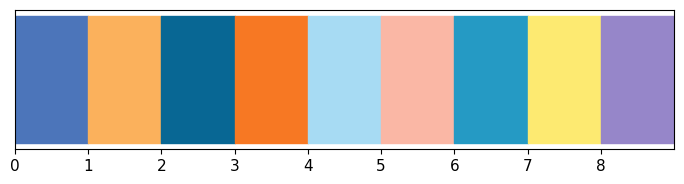

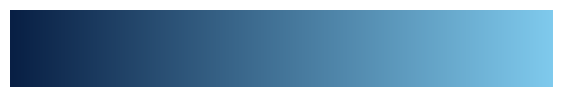

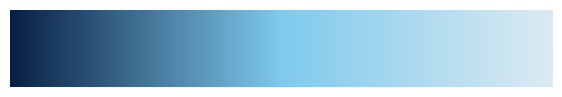

In [2]:
# create custom colormaps
hex_colors = ['#4c75ba', "#fbb15c", "#086794", "#f77823", '#a7dbf3',  "#fab7a5",  "#259ac4",  "#fdea71", "#9686c9"]
continuous_cmap = LinearSegmentedColormap.from_list('blue_lightblue', ['#081f44', "#7fcaed"])
continuous_cmap_towhite = LinearSegmentedColormap.from_list('blue_white', ['#081f44',"#7fcaed", "#dceaf2"]) # for heatmaps

plt.figure(figsize=(7, 2))
for i, hex_color in enumerate(hex_colors):
    plt.fill_between([i, i+1], 0, 1, color=hex_color)
plt.xlim(0, len(hex_colors))
plt.yticks([])
plt.xticks(range(len(hex_colors)), [i for i in range(len(hex_colors))])
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 1))
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=continuous_cmap)
plt.axis('off')
plt.show()
plt.figure(figsize=(7, 1))
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=continuous_cmap_towhite)
plt.axis('off')
plt.show()

## Data loading and preprocessing

In [3]:
# load AIS data
df_ais = pd.read_csv('ais_data.csv')
df_ais.head()

,timestamp,IMO Number,latitude,longitude
0,2024-06-02,1000000,43.582539,7.141050
1,2024-06-03,1000000,43.582989,7.140335
2,2024-06-04,1000000,43.582741,7.139882
3,2024-06-05,1000000,43.582470,7.140702
4,2024-06-06,1000000,43.583111,7.140595


In [4]:
# load fleet data
df_fleet_full = pd.read_excel('fleet_data.xlsx')
df_fleet_full.head()

,IMO Number,Vessel Name,Vessel Segment,Vessel Section,Fleet | Orderbook,Contract Date,Build Date,Owner Group,Owner,Owner Nationality,...,Main Engine RPM Range,Main Engine RPM,Competitor main engine model,"Main Engine, MW","Main engine unit, MW","Main Engine, No. units","Aux Engine, MW","Aux Engine, No. units",Fuel Type,Fuel
0,1000769,VES_1,Ferries,Ferries,Fleet,2002-07-01,2003-04-01,OWN_GRP_1,OWN_1,Madeira,...,Medium,735.0,COM_1,15.990,7.995,2,3.57,3,Alternative,Biofuel
1,1001089,VES_2,Containerships,Containerships,Fleet,2004-04-01,2005-03-01,OWN_GRP_2,OWN_2,Finland,...,Medium,500.0,COM_2,7.200,7.200,1,1.03,2,Alternative,Biofuel
2,1001549,VES_3,Containerships,Containerships,Fleet,2005-08-04,2010-06-01,OWN_GRP_3,OWN_3,Madeira,...,Medium,500.0,COM_3,7.200,7.200,1,2.04,2,Alternative,Biofuel
3,1001818,VES_4,Containerships,Containerships,Fleet,2006-03-17,2009-07-01,OWN_GRP_4,OWN_4,Iceland,...,Medium,500.0,COM_3,9.000,9.000,1,3.36,2,Alternative,Biofuel
4,1001836,VES_5,Wet cargo,Chemical Tankers,Fleet,2007-05-18,2009-05-01,OWN_GRP_5,OWN_5,Italy,...,Medium,600.0,COM_1,3.837,3.837,1,1.86,3,Alternative,Biofuel


In [5]:
print(df_ais.info())
print()
print(df_fleet_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921647 entries, 0 to 921646
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   timestamp   921647 non-null  object 
 1   IMO Number  921647 non-null  int64  
 2   latitude    921647 non-null  float64
 3   longitude   921647 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.1+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   IMO Number                    2963 non-null   object        
 1   Vessel Name                   2965 non-null   object        
 2   Vessel Segment                2965 non-null   object        
 3   Vessel Section                2728 non-null   object        
 4    Fleet | Orderbook            2965 non-null   object        


In [6]:
# fix dtypes
df_ais['timestamp'] = pd.to_datetime(df_ais['timestamp'], format='%Y-%m-%d')
df_fleet_full['IMO Number'] = pd.to_numeric(df_fleet_full['IMO Number'], errors='coerce').astype('Int64')

In [7]:
# Check for duplicate IMO Numbers in df_fleet_full
df_fleet_full[df_fleet_full.duplicated(subset=['IMO Number'], keep=False)]

,IMO Number,Vessel Name,Vessel Segment,Vessel Section,Fleet | Orderbook,Contract Date,Build Date,Owner Group,Owner,Owner Nationality,...,Main Engine RPM Range,Main Engine RPM,Competitor main engine model,"Main Engine, MW","Main engine unit, MW","Main Engine, No. units","Aux Engine, MW","Aux Engine, No. units",Fuel Type,Fuel
42,0,VES_43,Other,NaN,Fleet,1994-01-01,1995-01-01,OWN_GRP_26,OWN_30,Netherlands,...,Medium,1000.0,COM_9,1.020,1.020000,1,0.000,2,Conventional,Conventional
44,<NA>,VES_45,Dry cargo,MPP,Fleet,2004-01-01,2006-03-01,OWN_GRP_28,OWN_32,China P.R.,...,Medium,600.0,COM_6,2.940,2.940000,1,0.840,3,Conventional,Conventional
45,0,VES_46,Dry cargo,MPP,Fleet,2004-01-01,2006-02-01,OWN_GRP_29,OWN_33,China P.R.,...,Medium,750.0,COM_7,2.970,2.970000,1,0.761,3,Conventional,Conventional
46,0,VES_47,Other,NaN,Fleet,1993-01-01,1994-03-01,OWN_GRP_30,OWN_34,Germany,...,Medium,1000.0,COM_9,1.020,1.020000,1,0.057,2,Conventional,Conventional
47,<NA>,VES_48,Other,NaN,Fleet,1997-01-01,1998-01-01,OWN_GRP_31,OWN_35,Netherlands,...,Medium,930.0,COM_9,2.280,1.140000,2,0.000,2,Conventional,Conventional
48,0,VES_49,Other,NaN,Fleet,2002-01-01,2003-06-01,OWN_GRP_32,OWN_36,Netherlands,...,Medium,1000.0,COM_9,1.520,1.520000,1,0.148,2,Conventional,Conventional
49,0,VES_50,Other,NaN,Fleet,1994-01-01,1995-01-01,OWN_GRP_26,OWN_30,Netherlands,...,Medium,950.0,COM_9,1.320,1.320000,1,0.000,2,Conventional,Conventional
50,0,VES_51,Other,NaN,Fleet,2004-01-01,2006-01-01,OWN_GRP_33,OWN_37,Paraguay,...,Medium,1000.0,COM_9,0.838,0.838000,1,0.000,1,Conventional,Conventional
51,0,VES_52,Other,NaN,Fleet,1995-01-01,1996-01-01,OWN_GRP_34,OWN_38,Germany,...,Medium,1000.0,COM_9,2.096,1.048000,2,0.000,1,Conventional,Conventional
52,0,VES_53,Dry cargo,MPP,Fleet,2008-03-01,2010-03-01,OWN_GRP_35,OWN_39,China P.R.,...,Medium,600.0,COM_10,2.664,2.664000,1,1.207,2,Conventional,Conventional


23 vessels do not have valid IMO numbers.

### Exclude engines out of scope by table
As a first step to retrieve the addressable engines, we use the provided table to exclude from the analysis engines whose RMP or MW are out of scope.

In [8]:
# Exclude main engines with RPM or MW out of scope by table, except for diesel (all included)
filters = [{'engines': ['COM_8', 'COM_9'],
            'min_rpm': 900,
            'max_rpm': 1000,
            'min_mw': 1,
            },
           {'engines': ['COM_1', 'COM_10', 'COM_13'],
            'min_rpm': 720,
            'max_rpm': 750,
            'min_mw': 3.5,
            }]


# keep all diesels
enginetype_col = df_fleet_full['Main Engine Power Type']
keep_mask = enginetype_col.str.contains("diesel", case=False, na=False)

# collect all engines mentioned in filters
all_filter_engines = {e for f in filters for e in f['engines']}

# keep rows that match a filter
enginemodel_col = df_fleet_full['Competitor main engine model']
for f in filters:
    m = (
        enginemodel_col.isin(f['engines']) &
        (df_fleet_full['Main Engine RPM'] >= f['min_rpm']) &
        (df_fleet_full['Main Engine RPM'] <= f['max_rpm']) &
        (df_fleet_full['Main Engine, MW'] >= f['min_mw'])
    )
    keep_mask = keep_mask | m # or

# keep engines not covered by any filter
keep_mask = keep_mask | ~enginemodel_col.isin(all_filter_engines)

df_fleet_scopefilter = df_fleet_full[keep_mask].copy()
df_fleet_scopefilter.head()

,IMO Number,Vessel Name,Vessel Segment,Vessel Section,Fleet | Orderbook,Contract Date,Build Date,Owner Group,Owner,Owner Nationality,...,Main Engine RPM Range,Main Engine RPM,Competitor main engine model,"Main Engine, MW","Main engine unit, MW","Main Engine, No. units","Aux Engine, MW","Aux Engine, No. units",Fuel Type,Fuel
0,1000769,VES_1,Ferries,Ferries,Fleet,2002-07-01,2003-04-01,OWN_GRP_1,OWN_1,Madeira,...,Medium,735.0,COM_1,15.99,7.995,2,3.570,3,Alternative,Biofuel
1,1001089,VES_2,Containerships,Containerships,Fleet,2004-04-01,2005-03-01,OWN_GRP_2,OWN_2,Finland,...,Medium,500.0,COM_2,7.20,7.200,1,1.030,2,Alternative,Biofuel
2,1001549,VES_3,Containerships,Containerships,Fleet,2005-08-04,2010-06-01,OWN_GRP_3,OWN_3,Madeira,...,Medium,500.0,COM_3,7.20,7.200,1,2.040,2,Alternative,Biofuel
3,1001818,VES_4,Containerships,Containerships,Fleet,2006-03-17,2009-07-01,OWN_GRP_4,OWN_4,Iceland,...,Medium,500.0,COM_3,9.00,9.000,1,3.360,2,Alternative,Biofuel
5,1001890,VES_6,Containerships,Containerships,Fleet,2008-03-25,2011-02-01,OWN_GRP_6,OWN_6,Germany,...,Medium,500.0,COM_3,8.40,8.400,1,1.494,2,Alternative,Biofuel


### Exclude ships by age
Secondly, ships that are too young (<=10 years old) or with remaining useful life of less than 7 years should be excluded too. We compute these values with a monthly precision.

In [9]:
today = pd.Timestamp.today()

# ship age in months, then convert to years to achieve precision by month
age_months = (today.year - df_fleet_scopefilter['Build Date'].dt.year) * 12 + (today.month - df_fleet_scopefilter['Build Date'].dt.month)
df_fleet_scopefilter['Ship Age'] = age_months / 12

# remaining useful life
df_fleet_scopefilter['RUL'] = df_fleet_scopefilter['Scrapping age'] - df_fleet_scopefilter['Ship Age']

# mask: apply required filter
age_mask = (df_fleet_scopefilter['Ship Age'] > 10) & (df_fleet_scopefilter['RUL'] >= 7)

df_fleet = df_fleet_scopefilter[age_mask].copy()
df_fleet.head()

,IMO Number,Vessel Name,Vessel Segment,Vessel Section,Fleet | Orderbook,Contract Date,Build Date,Owner Group,Owner,Owner Nationality,...,Competitor main engine model,"Main Engine, MW","Main engine unit, MW","Main Engine, No. units","Aux Engine, MW","Aux Engine, No. units",Fuel Type,Fuel,Ship Age,RUL
0,1000769,VES_1,Ferries,Ferries,Fleet,2002-07-01,2003-04-01,OWN_GRP_1,OWN_1,Madeira,...,COM_1,15.990,7.995,2,3.570,3,Alternative,Biofuel,22.416667,18.583333
2,1001549,VES_3,Containerships,Containerships,Fleet,2005-08-04,2010-06-01,OWN_GRP_3,OWN_3,Madeira,...,COM_3,7.200,7.200,1,2.040,2,Alternative,Biofuel,15.250000,9.750000
3,1001818,VES_4,Containerships,Containerships,Fleet,2006-03-17,2009-07-01,OWN_GRP_4,OWN_4,Iceland,...,COM_3,9.000,9.000,1,3.360,2,Alternative,Biofuel,16.166667,8.833333
5,1001890,VES_6,Containerships,Containerships,Fleet,2008-03-25,2011-02-01,OWN_GRP_6,OWN_6,Germany,...,COM_3,8.400,8.400,1,1.494,2,Alternative,Biofuel,14.583333,10.416667
6,1002156,VES_7,Dry cargo,MPP,Fleet,2008-04-17,2011-01-01,OWN_GRP_7,OWN_7,Germany,...,COM_4,2.927,2.927,1,0.680,1,Alternative,Biofuel,14.666667,23.333333


In [10]:
# Automatically define vessel palette by mapping vessel segments to colors from hex colors
unique_segments = df_fleet['Vessel Segment'].unique()
vessel_palette = {segment: hex_colors[i % len(hex_colors)] for i, segment in enumerate(unique_segments)}

## Data Analysis

### Market potential by segment and costumer
Since the company has limited time and resources, it is important to focus the sales efforts where there is the highest potential return. Therefore, it is critical to identify the top customers not just by the number of vessels they operate, but by the total power (MW) of their addressable fleet. This metric directly correlates to the scale of the commercial opportunity, as larger, more powerful engines represent greater potential revenue, more significant fuel savings for the customer, and a stronger business case for repowering. This analysis ranks owners by their total megawatt opportunity to ensure we prioritise the most valuable targets effectively.

In [11]:
# Analyse by vessel segment
segment_analysis = df_fleet.groupby('Vessel Segment').agg(
    no_vessels=('IMO Number', 'count'),
    total_power_MW=('Main Engine, MW', 'sum'),
    avg_power_MW=('Main Engine, MW', 'mean')
).sort_values('total_power_MW', ascending=False)

print("Top vessel segments by repowering potential:")
print(segment_analysis.head(10))

Top vessel segments by repowering potential:
                no_vessels  total_power_MW  avg_power_MW
Vessel Segment                                          
Dry cargo              751        2296.390      3.053710
Offshore               219        1431.718      6.537525
Wet cargo              211         787.614      3.732768
PCC & Ro-Ro             54         727.853     13.478759
Cruise                  19         699.538     36.817789
Ferries                 41         696.367     16.984561
Containerships          86         685.219      7.967663
Other                  158         653.868      4.086675
Gas carriers            15          76.686      5.112400


In [12]:
# Analyse by owner (top customers)
owner_analysis = df_fleet.groupby('Owner').agg(
    no_vessels=('IMO Number', 'count'),
    total_power_MW=('Main Engine, MW', 'sum'),
    avg_vessel_age=('Ship Age', 'mean')
).sort_values('total_power_MW', ascending=False)

# Filter for owners with at least 2 vessels
top_10_owners = owner_analysis[owner_analysis['no_vessels'] >= 2].head(10)

print("Top 10 owners by total power (MW):")
print(top_10_owners)


Top 10 owners by total power (MW):
          no_vessels  total_power_MW  avg_vessel_age
Owner                                               
OWN_20             7         252.000       15.452381
OWN_377           11         178.252       19.780303
OWN_7             39         165.248       15.709402
OWN_9              2         130.000       16.250000
OWN_651            8         113.386       16.239583
OWN_434            4         112.800       19.708333
OWN_43            36         104.199       19.113426
OWN_1154           4          95.760       26.958333
OWN_401           13          76.121       17.846154
OWN_156            5          71.680       25.800000


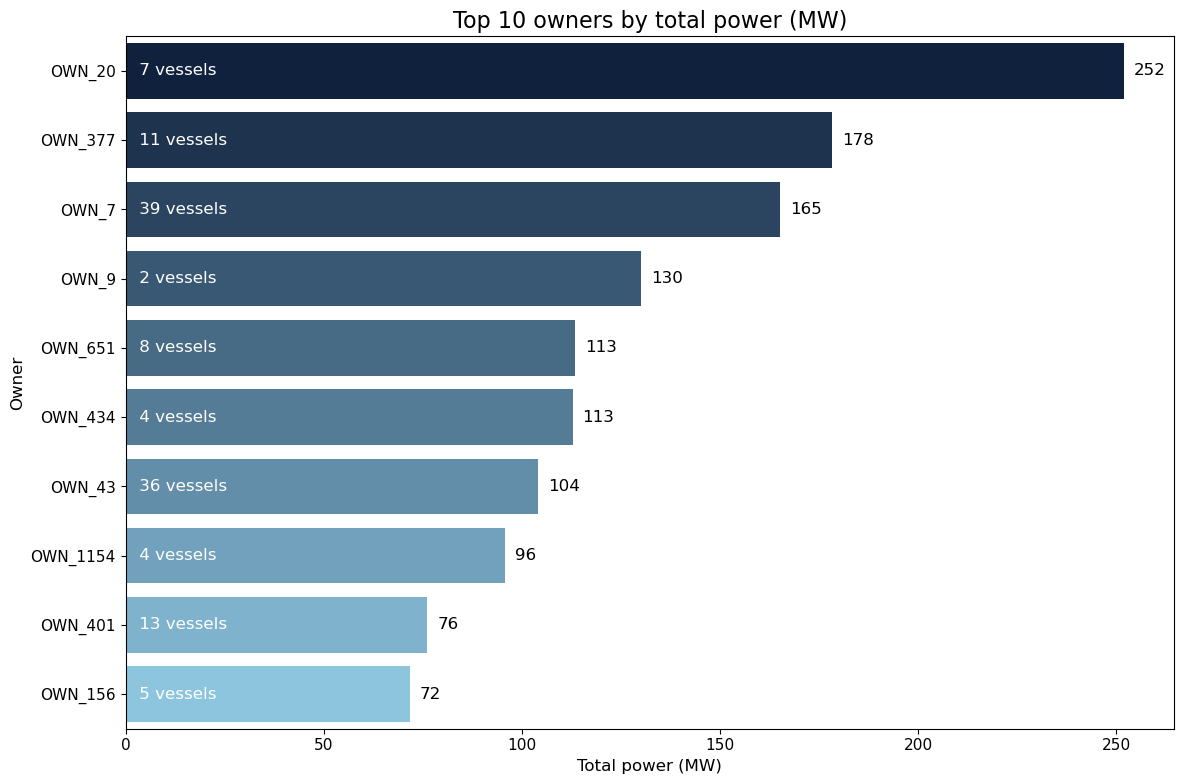

In [13]:
# visualise the top owners
plt.figure(figsize=(12, 8))

ax = sns.barplot(
    data=top_10_owners.reset_index(),
    y='Owner',
    x='total_power_MW',
    palette=[continuous_cmap(i / (len(top_10_owners) - 1)) for i in range(len(top_10_owners))],
)
plt.title('Top 10 owners by total power (MW)', fontsize=16)
plt.xlabel('Total power (MW)')
plt.ylabel('Owner')

# add value labels on the bars
for i, v in enumerate(top_10_owners['total_power_MW']):
    ax.text(v + max(top_10_owners['total_power_MW'])*0.01, i, f'{v:,.0f}', ha='left', va='center', fontsize =12) 

# add the number of vessels
for i, (idx, row) in enumerate(top_10_owners.iterrows()):
    ax.text(2, i, f' {row["no_vessels"]} vessels', ha='left', va='center', color='white', fontsize =12) 

plt.tight_layout()
plt.show()

**Vessel Segment Analysis**  
The analysis reveals three distinct tiers of market potential based on total addressable power (MW):  
1. The Dry Cargo segment represents the single largest opportunity by volume (751 vessels) and total power (2,296 MW), making it an essential target for a repowering campaign.
2. The Offshore segment is very important. Despite having less than a third of the vessels of the Dry Cargo segment, it offers the second-highest total power (1,431 MW). This indicates that offshore vessels typically have more powerful engines, presenting a concentrated high-value opportunity.
3. The PCC & Ro-Ro and Cruise segments, though smaller in vessel count, show a very high average power per vessel (13.5 MW and 36.8 MW respectively). These segments should be prioritised for their potential for significant fuel savings and high-value individual projects, offering an efficient way to increase MW revenue with fewer sales. Notably, the Wet Cargo segment (211 vessels, 787 MW) also represents a substantial volume-based opportunity.

**Owner Analysis**  
Prioritising owners by total addressable power, rather than fleet size, better identifies customers where repowering projects will have the greatest operational and financial impact.

* OWN_20 and OWN_377 emerge as top-tier targets, representing the largest MW opportunities despite a modest number of vessels. This suggests they operate a fleet of high-powered assets.
* OWN_7 presents a strategic account opportunity, possessing both a large fleet (39 vessels) and substantial total power (165 MW), indicating a potential candidate for a fleet-wide repowering program.
* The above-average age of OWN_1154's fleet (27 years) is a key finding. While their total power is high, the advanced age of their vessels may place them closer to scrapping than repowering.

*Conclusion*: The sales strategy should be multi-faceted: a broad push in the Dry Cargo and Wet Cargo segments, targeted engagement with high-power Offshore, PCC & Ro-Ro, and Cruise operators, and focused account-based marketing towards the top owners identified by total MW potential.

### Fleet age and lifecycle
The age of a vessel is the primary indicator of its repowering potential. Engines and ships have a typical lifespan, making repowering a 5-year-old vessel financially illogical, while a 20-year-old vessel represents a better candidate. This analysis profiles the age distribution of our addressable fleet to identify the "sweet spot", i.e. the age window where the majority of candidates reside. Understanding this distribution allows the company to time its sales pitch strategically and forecast future market demand.

In [14]:
# Calculate statistics
mean_age = df_fleet['Ship Age'].mean()
median_age = df_fleet['Ship Age'].median()
age_std = df_fleet['Ship Age'].std()
mode_age = df_fleet['Ship Age'].mode()[0]

print(f"Mean age: {mean_age:.2f} years")
print(f"Median age: {median_age:.2f} years")
print(f"Age standard deviation: {age_std:.2f} years")
print(f"Mode age: {mode_age:.2f} years")

Mean age: 18.31 years
Median age: 17.50 years
Age standard deviation: 4.37 years
Mode age: 17.92 years


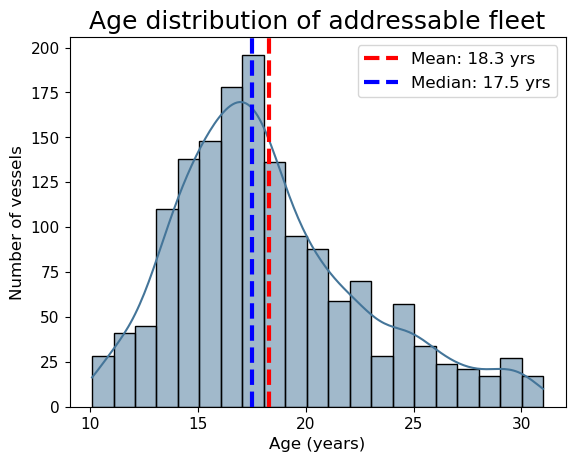

In [15]:
age_range = round(max(df_fleet['Ship Age']) - min(df_fleet['Ship Age']))
sns.histplot(data=df_fleet, x='Ship Age', kde=True, bins=age_range, color=continuous_cmap(0.5))
plt.axvline(mean_age, color='red', linestyle='--', label=f'Mean: {mean_age:.1f} yrs', lw=3)
plt.axvline(median_age, color='blue', linestyle='--', label=f'Median: {median_age:.1f} yrs', lw = 3)
plt.title('Age distribution of addressable fleet')
plt.xlabel('Age (years)')
plt.ylabel('Number of vessels')
_ = plt.legend()

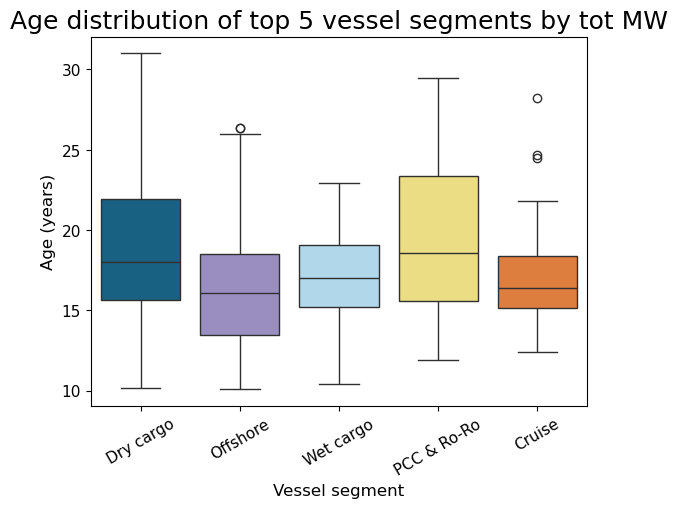

In [16]:
top_segments = segment_analysis.head(5).index
df_top_segments = df_fleet[df_fleet['Vessel Segment'].isin(top_segments)]
df_top_segments['Vessel Segment'] = pd.Categorical(df_top_segments['Vessel Segment'], categories=top_segments, ordered=True)

sns.boxplot(
    data=df_top_segments,
    x='Vessel Segment',
    y='Ship Age',
    palette=vessel_palette
)
plt.title('Age distribution of top 5 vessel segments by tot MW')
plt.xlabel('Vessel segment')
plt.ylabel('Age (years)')
plt.tick_params(axis='x', rotation=30)


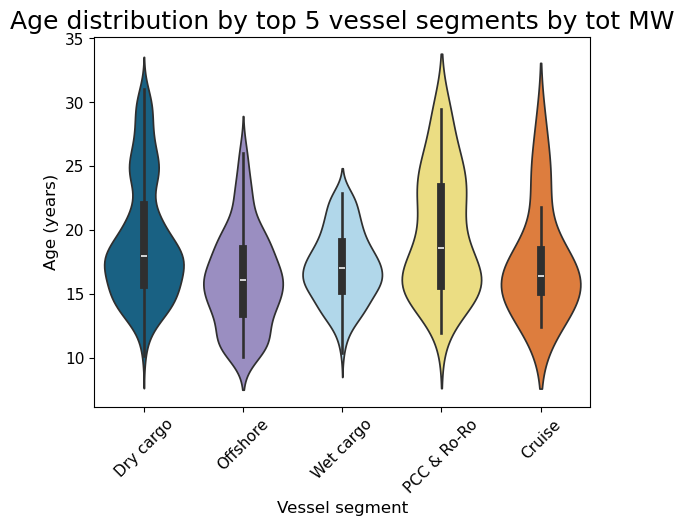

In [17]:
sns.violinplot(data=df_top_segments, x='Vessel Segment', y='Ship Age', palette=vessel_palette)
plt.title('Age distribution by top 5 vessel segments by tot MW')
plt.xlabel('Vessel segment')
plt.ylabel('Age (years)')
plt.tick_params(axis='x', rotation=45)

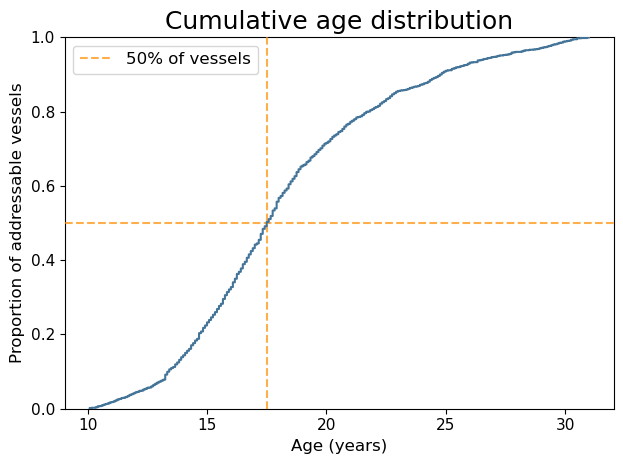

In [18]:
sns.ecdfplot(data=df_fleet, x='Ship Age', color= continuous_cmap(0.5), zorder = 100, lw = 1.5)
plt.axhline(0.5, color='darkorange', linestyle='--', alpha=0.7, label='50% of vessels', zorder = 10)
plt.axvline(median_age, color='darkorange', linestyle='--', alpha=0.7, zorder = 10)
plt.title('Cumulative age distribution')
plt.xlabel('Age (years)')
plt.ylabel('Proportion of addressable vessels')
plt.legend()

plt.tight_layout()
plt.show()


Age bracket distribution:
0-10 years: 0 vessels (0.0%)
10-15 years: 349 vessels (22.4%)
15-20 years: 762 vessels (48.9%)
20-25 years: 302 vessels (19.4%)
25-30 years: 126 vessels (8.1%)
30-35 years: 18 vessels (1.2%)
35+ years: 0 vessels (0.0%)


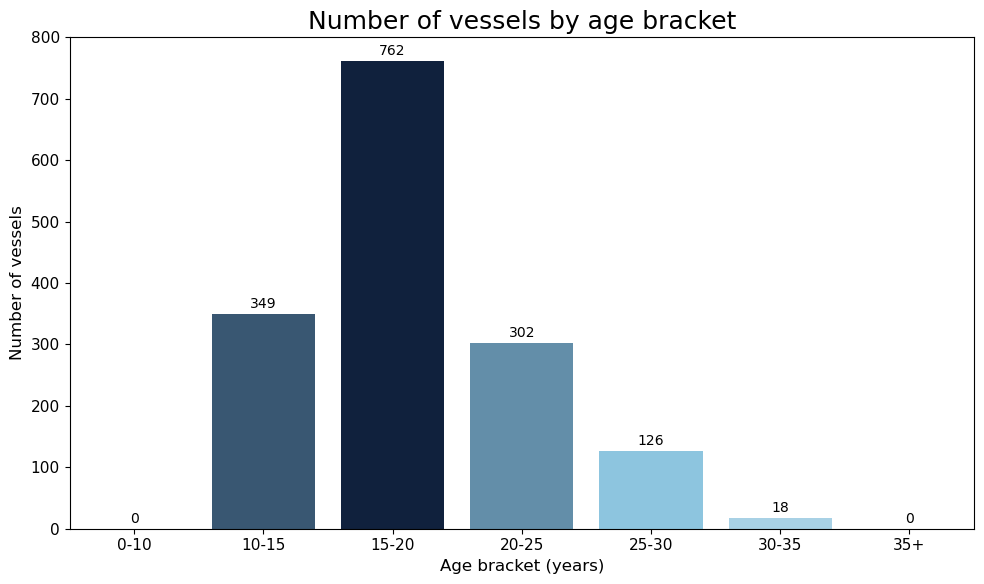

In [19]:
# Calculate and display the proportion of vessels in different age brackets
age_bins = [0, 10, 15, 20, 25, 30, 35, 100]
age_labels = ['0-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
df_fleet['Age_Bracket'] = pd.cut(df_fleet['Ship Age'], bins=age_bins, labels=age_labels, right=False)

age_bracket_counts = df_fleet['Age_Bracket'].value_counts().sort_index()
age_bracket_percs = (age_bracket_counts / len(df_fleet) * 100).round(1)

print("\nAge bracket distribution:")
for bracket, count, perc in zip(age_bracket_counts.index, age_bracket_counts.values, age_bracket_percs.values):
    print(f"{bracket} years: {count} vessels ({perc}%)")

rank = age_bracket_counts.argsort().argsort()

# bar plot for age brackets
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x=age_bracket_counts.index,
    y=age_bracket_counts.values,
    palette=np.array([continuous_cmap_towhite(i / (len(age_bracket_counts) - 1)) for i in range(len(age_bracket_counts)-1, -1, -1)])[rank]
)
plt.title('Number of vessels by age bracket')
plt.xlabel('Age bracket (years)')
plt.ylabel('Number of vessels')

default_width = bars.patches[0].get_width()
# Add value labels on top of bars
for i, v in enumerate(age_bracket_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [20]:
# Analysis of vessels in prime repowering age range (10-25 years)
prime_age_vessels = df_fleet[(df_fleet['Ship Age'] >= 10) & (df_fleet['Ship Age'] <= 25)]
prime_age_percent = (len(prime_age_vessels) / len(df_fleet)) * 100

print(f"\nVessels in prime repowering age range (10-25 years): {len(prime_age_vessels)}")
print(f"This represents {prime_age_percent:.1f}% of the addressable fleet")

# Breakdown by segment
print("\nPrime repowering vessels by segment:")
print(prime_age_vessels['Vessel Segment'].value_counts())


Vessels in prime repowering age range (10-25 years): 1417
This represents 91.0% of the addressable fleet

Prime repowering vessels by segment:
Vessel Segment
Dry cargo         640
Offshore          213
Wet cargo         211
Other             160
Containerships     86
PCC & Ro-Ro        45
Ferries            30
Cruise             18
Gas carriers       14
Name: count, dtype: int64


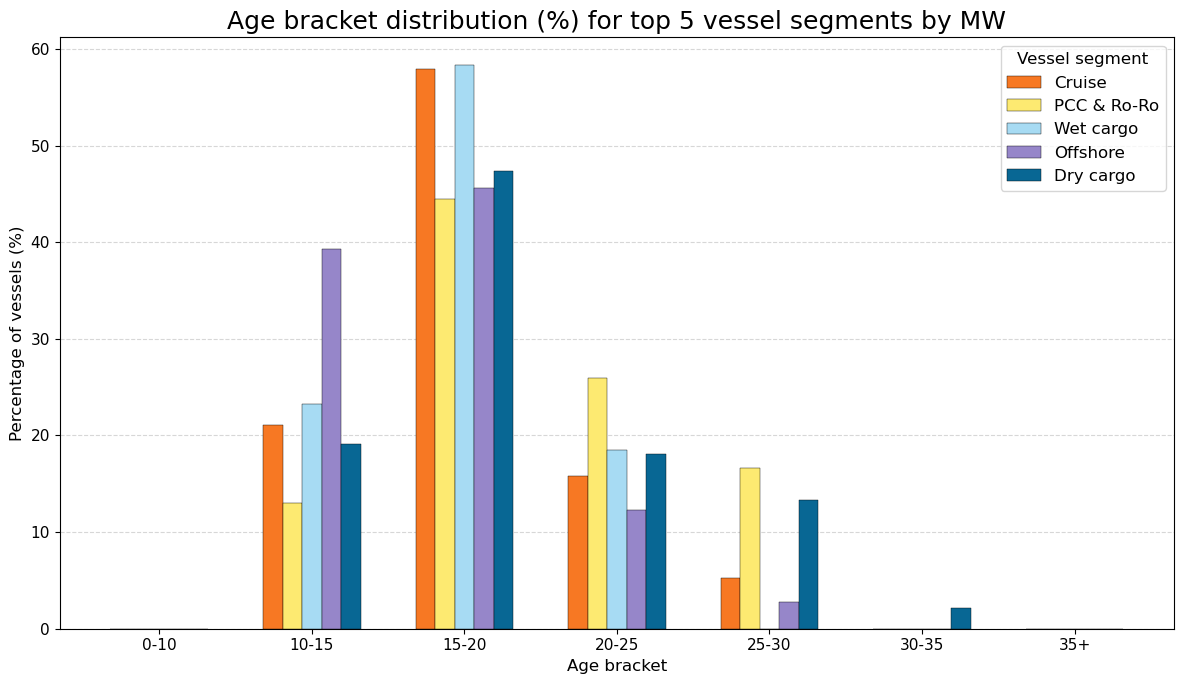

In [21]:
top5_segments = segment_analysis.head(5).index[::-1]
df_top5 = df_fleet[df_fleet['Vessel Segment'].isin(top5_segments)]
df_top5['Age_Bracket'] = pd.cut(df_top5['Ship Age'], bins=age_bins, labels=age_labels, right=False)

# Ensure all age brackets are present for each segment
age_bracket_counts = (
    df_top5.groupby(['Vessel Segment', 'Age_Bracket'], observed=True)
    .size()
    .unstack(fill_value=0)
    .reindex(index=top5_segments, columns=age_labels, fill_value=0)
)
age_bracket_perc = age_bracket_counts.div(age_bracket_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 7))
age_brackets = age_bracket_perc.columns
bar_width = 0.13
x = np.arange(len(age_brackets))

# ensure same total with as previous barplot
bar_width = default_width / 5 * 0.8  # slight scaling for spacing

for i, segment in enumerate(top5_segments):
    ax.bar(
        x + i * bar_width,
        age_bracket_perc.loc[segment].values,
        width=bar_width,
        label=segment,
        color=vessel_palette.get(segment, None),
        edgecolor='black',
        linewidth=0.3,
        zorder=100,
    )

ax.set_xticks(x + bar_width * (len(top5_segments) - 1) / 2)
ax.set_xticklabels(age_brackets)
ax.set_xlabel("Age bracket")
ax.set_ylabel("Percentage of vessels (%)")
ax.set_title("Age bracket distribution (%) for top 5 vessel segments by MW")
ax.legend(title="Vessel segment") #, loc='upper left')#, bbox_to_anchor=(1, 1))
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
plt.tight_layout()
plt.show()


The age profile of the addressable fleet is very promising and shows an urgent and substantial market opportunity.  
The data indicates a strikingly favourable age distribution for repowering opportunities. With a mean age of 18.3 years and a median of 17.5 years, the entire addressable fleet is positioned within the ideal phase for engine replacement decisions. The low standard deviation (4.4 years) confirms that the ages are tightly clustered, rather than being widely dispersed. 

A significant finding is that a remarkable 91% of the entire addressable fleet (1,417 vessels) falls within the prime repowering age range of 10-25 years. This concentration is a powerful indicator of a large and imminent market opportunity. The distribution within this range is particularly encouraging: 
- nearly half the addressable vessels (48.9%) are in the sweet spot of the 15-20 years, making them the most active leads in need of mid-life upgrades;
- another 22.4% of the fleet is found in the 10-15 age bracket, where they are most likely being monitored for future planning, and therefore could represent potential repowering projects in the next few years;
- 19.4% of the fleet is constituted by older vessels (20-25 years), representing the most time-sensitive opportunities, as the owners are probably making decisions between repowering and scrapping.

The distribution of prime repowering age vessels aligns with the previously identified high-potential segments, validating the market focus. Dry Cargo leads overwhelmingly with 640 vessels in the prime age range, solidifying its status as the highest-priority segment.
Offshore (213) and Wet Cargo (211) further cement their positions as priority segments with substantial, immediate opportunities.
The high-value PCC & Ro-Ro (45) and Cruise (18) segments, while smaller in number, have their fleets almost entirely within the prime window, making each individual vessel a high-value target.

### Operational patterns
How a vessel is used directly impacts the business case for repowering. A new, efficient engine's value is determined by how much it operates. This part of the analysis examines key operational metrics, including geographical regions, vessel utilisation rates, and travel patterns to identify vessels where the operational cost savings from a repowering project will be greatest. Vessels with high utilisation sailing in regions with high fuel costs or strict environmental regulations present the most compelling case for investment.

In [22]:
# Merge AIS data with the addressable fleet df
df_ais_merged = pd.merge(df_ais, df_fleet[['IMO Number', 'Vessel Segment', 'Owner']], on='IMO Number', how='inner')
print(f"Analysing AIS data for {df_ais_merged['IMO Number'].nunique()} unique vessels from the addressable fleet.")
df_ais_merged.head()

Analysing AIS data for 1513 unique vessels from the addressable fleet.


,timestamp,IMO Number,latitude,longitude,Vessel Segment,Owner
0,2024-06-02,1000000,43.582539,7.141050,Other,OWN_43
1,2024-06-03,1000000,43.582989,7.140335,Other,OWN_43
2,2024-06-04,1000000,43.582741,7.139882,Other,OWN_43
3,2024-06-05,1000000,43.582470,7.140702,Other,OWN_43
4,2024-06-06,1000000,43.583111,7.140595,Other,OWN_43


#### Utilisation rate by vessel segment

Number of AIS records below movement threshold: 117151 (23.8%)


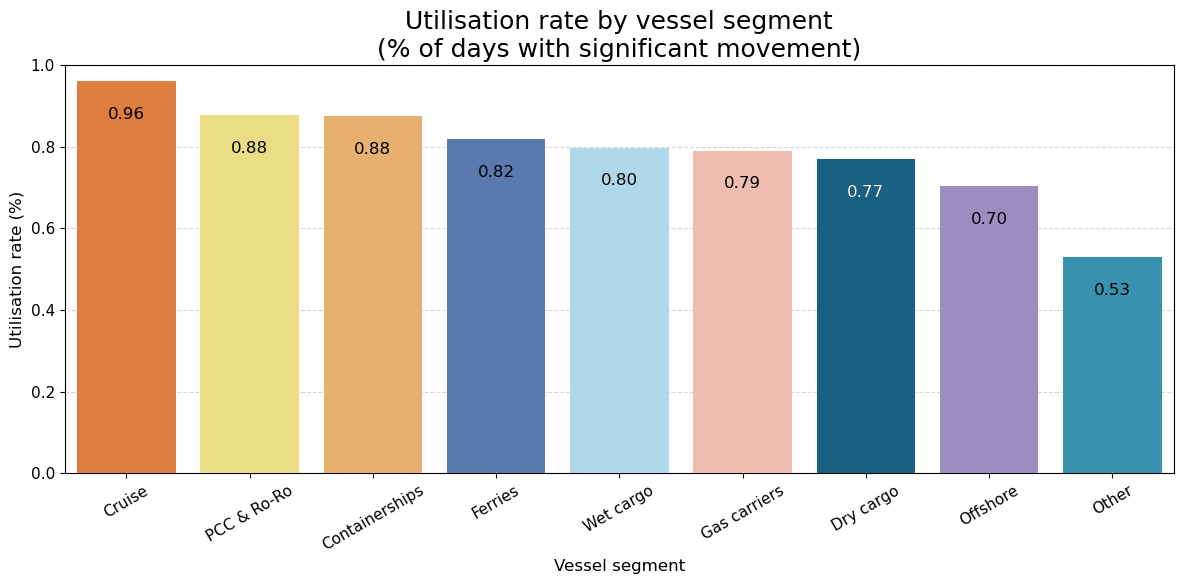

In [23]:
# calculate a proxy for utilisation based on position changes (a vessel that moves more is likely more used)
# calculate daily movement (distance from previous position) for each vessel
df_ais_merged = df_ais_merged.sort_values(['IMO Number', 'timestamp'])
df_ais_merged['prev_lat'] = df_ais_merged.groupby('IMO Number')['latitude'].shift(1)
df_ais_merged['prev_lon'] = df_ais_merged.groupby('IMO Number')['longitude'].shift(1)

# Calculate distance using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

df_ais_merged['daily_movement'] = np.where(
    df_ais_merged['IMO Number'] == df_ais_merged['IMO Number'].shift(1),
    haversine(df_ais_merged['prev_lat'], df_ais_merged['prev_lon'], 
                      df_ais_merged['latitude'], df_ais_merged['longitude']),
    np.nan
)

# calculate utilisation proxy: percentage of days with significant movement
util_thres = 0.1  # degrees of movement threshold
df_ais_merged['was_active'] = df_ais_merged['daily_movement'] > util_thres

# Print how many rows were filtered out (i.e., not active)
num_filtered_out = (~df_ais_merged['was_active']).sum()
print(f"Number of AIS records below movement threshold: {num_filtered_out} ({num_filtered_out / len(df_ais_merged) * 100:.1f}%)")

utilisation_by_vessel = df_ais_merged.groupby('IMO Number')['was_active'].mean()
utilisation_by_segment = df_ais_merged.groupby('Vessel Segment')['was_active'].mean().sort_values(ascending=False)


plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=utilisation_by_segment.index,
    y=utilisation_by_segment.values,
    palette=[vessel_palette.get(seg, '#333333') for seg in utilisation_by_segment.index],
    zorder = 100
)
plt.title('Utilisation rate by vessel segment\n(% of days with significant movement)')
plt.ylabel('Utilisation rate (%)')
plt.xlabel('Vessel segment')
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
plt.tight_layout()


# Add value labels above each bar
for i, rate in enumerate(utilisation_by_segment.values):
    ax.text(i, rate - 0.1, f'{rate:.2f}', ha='center', va='bottom', zorder = 1000)
    if utilisation_by_segment.index[i] == 'Dry cargo': # white text when dark background
        ax.text(i, rate - 0.1, f'{rate:.2f}', ha='center', va='bottom', zorder = 1000, color= 'white')

plt.show()

This chart reveals differences in how different vessel segments are operated, which directly impacts their repowering potential.
- Cruises, PCC & Ro-Ro and containerships operate at a very high rate. This indicates intensive and near-continuous use, making them prime targets for repowering. The fuel savings from a more efficient engine would be massive and provide a  fast return on investment.
- Ferries, wet and dry cargo, gas carriers, and offshore segments show moderate utilisation. They are frequently active but have more operational downtime. Their case for repowering is still strong, but it must be studiend more carefully.
- Other types of segments are used less often, suggesting irregular operations and long periods of anchorage. They can be considered secondary targets to the repowering project, as their case could be harder to justify on fuel savings alone.

The low utilisation of the Offshore segment is notable, given its high total power ranking seen earlier. This suggests these vessels are powerful but may spend a lot of time idle, which can pivot the repowering argument away from fuel savings and towards, perhaps, reliability.

#### Cluster by operational pattern

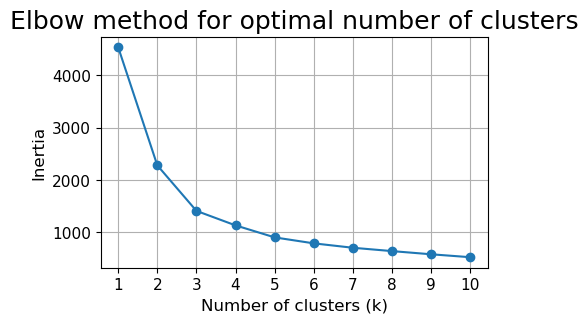

In [24]:
# Calculate metrics and scale
operational_metrics = df_ais_merged.groupby('IMO Number').agg({
    'daily_movement': 'mean',
    'latitude': 'std',
    'longitude': 'std'
}).fillna(0)
operational_metrics.columns = ['avg_daily_movement', 'north_south_range', 'east_west_range']

scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(operational_metrics)

# Use the Elbow method to find the best k for kMeans
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_metrics)
    inertia.append(kmeans.inertia_) # sum of squared distances to cluster center

# Plot the Elbow Curve
plt.figure(figsize=(5, 3))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal number of clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [25]:
# Apply kMeans clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
operational_metrics['operational_cluster'] = kmeans.fit_predict(scaled_metrics)

# Merge back with vessel information
operational_metrics = operational_metrics.reset_index().merge(
    df_fleet[['IMO Number', 'Vessel Segment', 'Ship Age']], 
    on='IMO Number', 
    how='left'
)

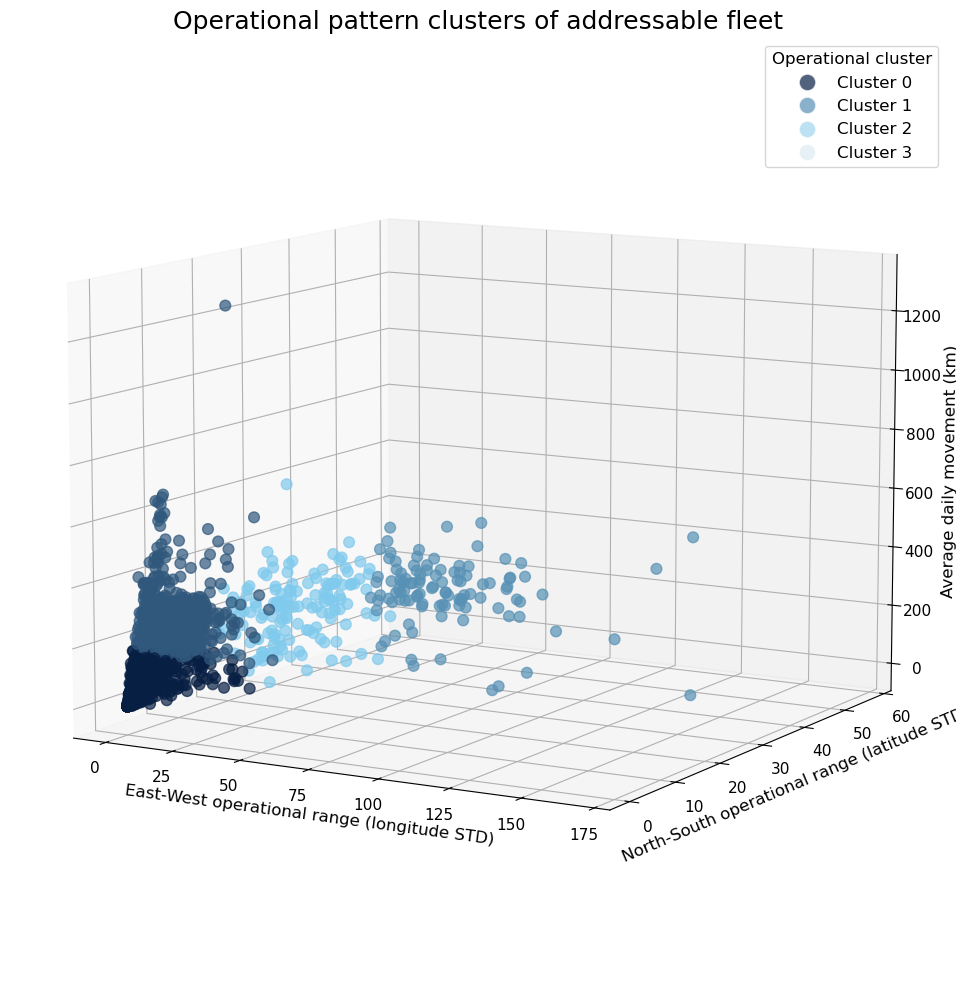

In [26]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10)  # Lower elevation for a flatter view

scatter = ax.scatter(
    operational_metrics['east_west_range'],
    operational_metrics['north_south_range'],
    operational_metrics['avg_daily_movement'],
    c=operational_metrics['operational_cluster'],
    cmap=continuous_cmap,
    s=60,
    alpha=0.7
)

ax.set_title('Operational pattern clusters of addressable fleet')
ax.set_xlabel('East-West operational range (longitude STD)')
ax.set_ylabel('North-South operational range (latitude STD)')
ax.set_zlabel('Average daily movement (km)')

cluster_labels = [f'Cluster {i}' for i in range(k)]
cluster_colors = [continuous_cmap_towhite(i / (k - 1)) for i in range(k)]
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=12, alpha=0.7)
                   for label, color in zip(cluster_labels, cluster_colors)]
ax.legend(handles=legend_elements, title='Operational cluster', loc='best')
plt.tight_layout()
plt.show()


In [27]:
# cluster characteristics
cluster_summary = operational_metrics.groupby('operational_cluster').agg({
    'avg_daily_movement': 'mean',
    'north_south_range': 'mean',
    'east_west_range': 'mean',
    'IMO Number': 'count',
    'Ship Age': 'mean'
}).round(2)
print("Operational Cluster Summary:")
print(cluster_summary)

Operational Cluster Summary:
                     avg_daily_movement  north_south_range  east_west_range  \
operational_cluster                                                           
0                                 63.06               2.17             2.95   
1                                267.80               5.14             9.19   
2                                328.25              24.70            74.76   
3                                254.63              18.66            29.22   

                     IMO Number  Ship Age  
operational_cluster                        
0                           555     17.96  
1                           708     18.82  
2                           107     17.01  
3                           143     17.86  


In [28]:
# distribution of vessel segments within each cluster
cluster_segment_dist = operational_metrics.groupby('operational_cluster')['Vessel Segment'].value_counts(normalize=True).unstack(fill_value=0)

print("Distribution of vessel segments by operational cluster (%):")
print(cluster_segment_dist)

Distribution of vessel segments by operational cluster (%):
Vessel Segment       Containerships    Cruise  Dry cargo   Ferries  \
operational_cluster                                                  
0                          0.021622  0.001802   0.180180  0.039640   
1                          0.104520  0.004237   0.645480  0.022599   
2                          0.000000  0.074766   0.841121  0.000000   
3                          0.000000  0.048951   0.664336  0.000000   

Vessel Segment       Gas carriers  Offshore     Other  PCC & Ro-Ro  Wet cargo  
operational_cluster                                                            
0                        0.000000  0.351351  0.212613     0.018018   0.174775  
1                        0.011299  0.007062  0.019774     0.050847   0.134181  
2                        0.018692  0.018692  0.000000     0.028037   0.018692  
3                        0.034965  0.118881  0.013986     0.020979   0.097902  


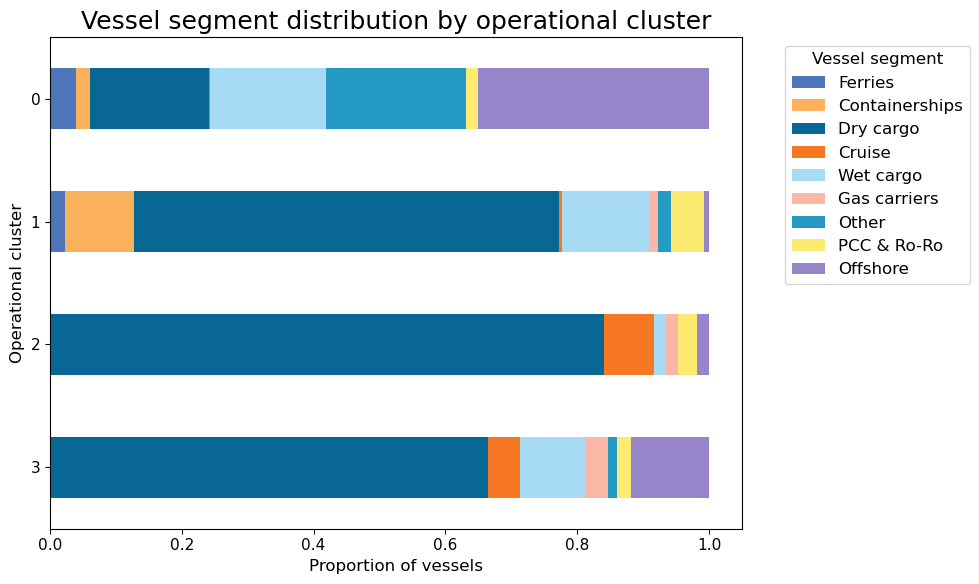

In [29]:
segment_order = [seg for seg in vessel_palette if seg in cluster_segment_dist.columns]
colors = [vessel_palette[seg] for seg in segment_order]

cluster_segment_dist = cluster_segment_dist[segment_order]
cluster_segment_dist.iloc[::-1].plot(kind='barh', stacked=True, color=colors, figsize=(10,6))
plt.xlabel('Proportion of vessels')
plt.ylabel('Operational cluster')
plt.title('Vessel segment distribution by operational cluster')
plt.legend(title='Vessel segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The K-Means clustering algorithm has identified 4 distint operational profiles within the addressable fleet, based on how the vessels are used. 
0. This cluster represents the vessels with the highest daily movement but smallest geographical range. It contains the majority of the PCC & Ro-Ro (18% of the cluster) and Containerships (28%) in the dataset, along with a large portion of Dry Cargo (35%). These are vessels on intense fixed schedules, constantly moving on predictable, short routes.
1. This cluster is characterised by hihg daily movement and the longest geographical range by far, suggesting ocean trade lines. This is confirmed by the overwhelming presence of Dry Cargo (83% of the cluster), with small contributions from Cruises and Offshore segments. Notably, it doesn't contain Containerships.
2. The most populated cluster, with medium daily movement and moderate geographical range. Like Cluster 1, it is composed mainly by Dry Cargo (69%) followed by Wet Cargo (16%) and a mix of all other segments, including Containerships (4%). This represents the core of the global fleet, operating actively but on more confined routes than Cluster 1.
3. This last cluster contains the stationary offshore and support fleet. It is characterised by low daily movement and a very small geographical range. It is dominated by the Offshore segment (38%) and Other (23%), with smaller portions of Dry and Wet cargo. 

This clusterisation provides another insight into the order of priority for repowering. Cluster 0 (short sea lines) represents the highest priority group, containing high-value, high-utilisation vessels types (PCC & Ro-Ro, Containerships). Cluster 1 closely follows, as the fuel savings for these long-range vessels would be significant. Cluster 2 holds a volume priority, being the largest, making it ideal for a broad campaign. Lastly, Cluster 3 can be considered low priority, especially for a fuel-saving argument.

#### Geolocalisation of operating patterns

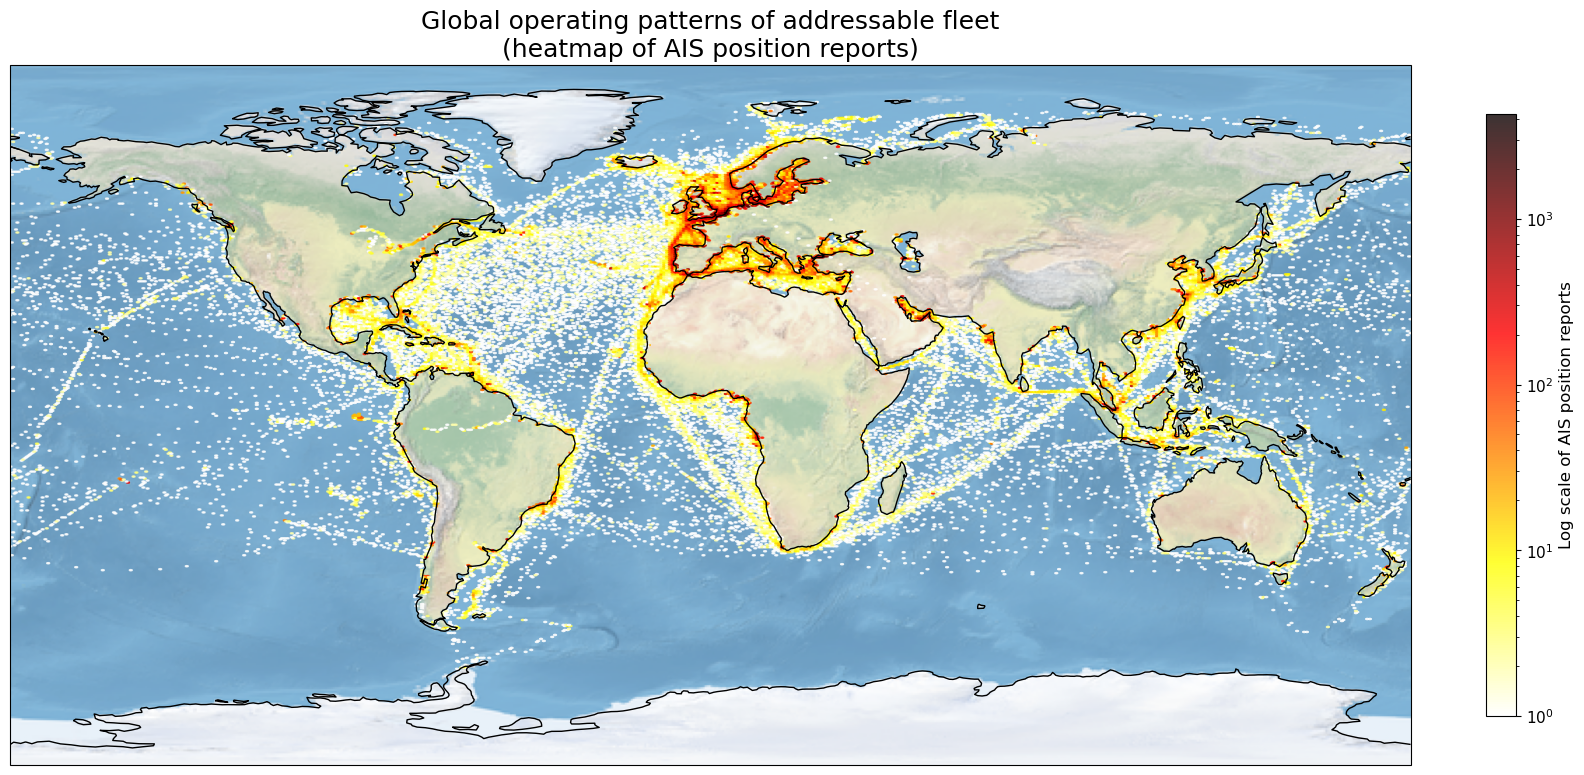

In [30]:
# Heatmap of operating patterns 
plt.figure(figsize=(16, 10))
# get background map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

# create a hexbin of vessel positions
h = plt.hexbin(df_ais_merged['longitude'], df_ais_merged['latitude'], 
               gridsize=500, cmap='hot_r', alpha=0.8, 
               mincnt=1, bins='log')

cb = plt.colorbar(h, ax=ax, orientation='vertical', pad=0.05, fraction=0.02)
cb.set_label('Log scale of AIS position reports')

plt.title('Global operating patterns of addressable fleet\n(heatmap of AIS position reports)')
plt.tight_layout()
plt.show()

In [31]:
# Define major shipping regions
# Source: www.marineregions.org
region_bins = {
    'Europe':        [(35, 70),  (-25, 40)],
    'North America': [(10, 75),  (-170, -50)],
    'East Asia':     [(20, 50),  (100, 145)],
    'Southeast Asia':[(-10, 25),  (90, 130)],
    'Indian Ocean':  [(-40, 25), (30, 110)],
    'North Atlantic':[(0, 70),   (-100, 20)],
    'South Atlantic':[(-60, 0),  (-70, 20)],
    'Pacific Ocean': [(-60, 60), (120, -80)], 
}

# We don't want intersecating regions
# assign the intersecated area to the region for which it constitutes the highest percentage overall

# convert to shapely polygons
polygons = {}
for name, ((lat_min, lat_max), (lon_min, lon_max)) in region_bins.items():
    if lon_min < lon_max:
        poly = box(lon_min, lat_min, lon_max, lat_max)
    else:
        # handle dateline: split into two polygons
        poly = unary_union([
            box(lon_min, lat_min, 180, lat_max),
            box(-180, lat_min, lon_max, lat_max)
        ])
    polygons[name] = poly

# resolve overlaps
final_polygons = polygons.copy()
for name1, poly1 in polygons.items():
    for name2, poly2 in polygons.items():
        # compare pairs only once
        if name1 >= name2:
            continue
        inter = poly1.intersection(poly2)
        if not inter.is_empty:
            area1 = inter.area / poly1.area
            area2 = inter.area / poly2.area
            # assign overlap to the region with higher relative coverage
            if area1 >= area2:
                # keep for 1, remove from 2
                final_polygons[name2] = final_polygons[name2].difference(inter)
            else:
                final_polygons[name1] = final_polygons[name1].difference(inter)

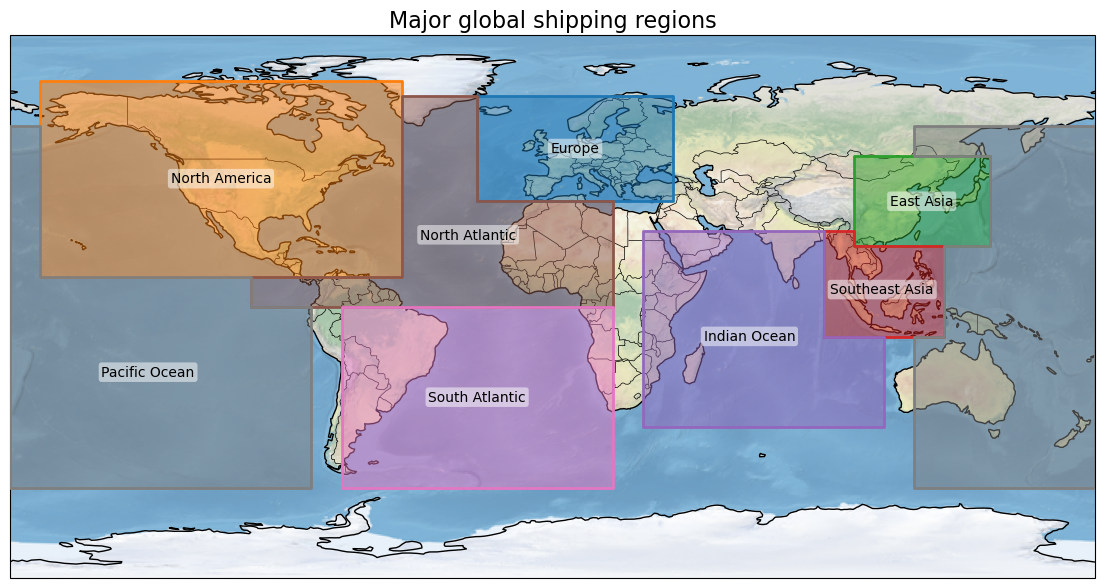

In [32]:
# visualise shipping regions
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title('Major global shipping regions', fontsize=16)
colors = itertools.cycle(plt.cm.tab10.colors)
for name, geom in final_polygons.items():
    color = next(colors)

    if geom.is_empty:
        continue

    # Ensure we can iterate individual polygon parts
    parts = geom.geoms if isinstance(geom, MultiPolygon) else [geom]

    for part in parts:
        # transparent fill
        ax.add_geometries(
            [part],
            crs=ccrs.PlateCarree(),
            facecolor=color,
            edgecolor='none',
            alpha=0.5, 
            zorder=2
        )
        
        # opaque border
        ax.add_geometries(
            [part],
            crs=ccrs.PlateCarree(),
            facecolor='none',
            edgecolor=color,
            linewidth=2,
            alpha=1.0,
            zorder=3
        )

    # Place black label at centroid of the largest part (so label sits in main chunk)
    largest = max(parts, key=lambda p: p.area)
    c = largest.centroid
    lon, lat = c.x, c.y
    ax.text(
        lon, lat, name,
        transform=ccrs.PlateCarree(),
        fontsize=10,
        ha='center',
        va='center',
        color='black', 
        zorder=4,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.5)  # white back for readability
    )

plt.show()

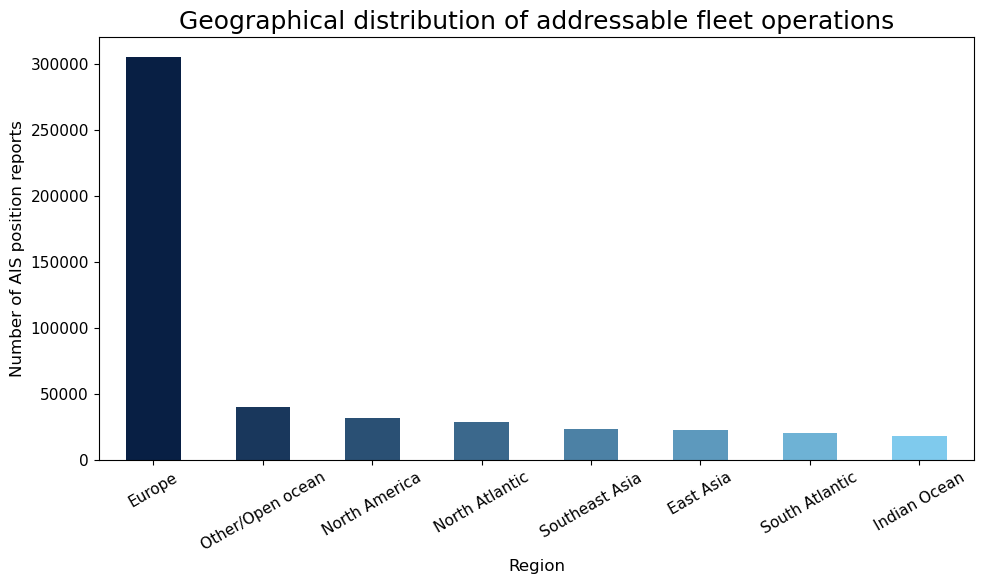

In [33]:
def assign_region(lat, lon):
    for region, bounds in region_bins.items():
        lat_bounds, lon_bounds = bounds
        if lat_bounds[0] <= lat <= lat_bounds[1] and lon_bounds[0] <= lon <= lon_bounds[1]:
            return region
    return 'Other/Open ocean'

df_ais_merged['Region'] = df_ais_merged.apply(lambda x: assign_region(x['latitude'], x['longitude']), axis=1)

# Plot regional distribution
region_counts = df_ais_merged['Region'].value_counts()
region_counts_sorted = region_counts.sort_values(ascending=False)
colors = [continuous_cmap(i / (len(region_counts_sorted) - 1)) for i in range(len(region_counts_sorted))]

plt.figure(figsize=(10, 6))
region_counts_sorted.plot(kind='bar', color=colors)
plt.title('Geographical distribution of addressable fleet operations')
plt.ylabel('Number of AIS position reports')
plt.xlabel('Region')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

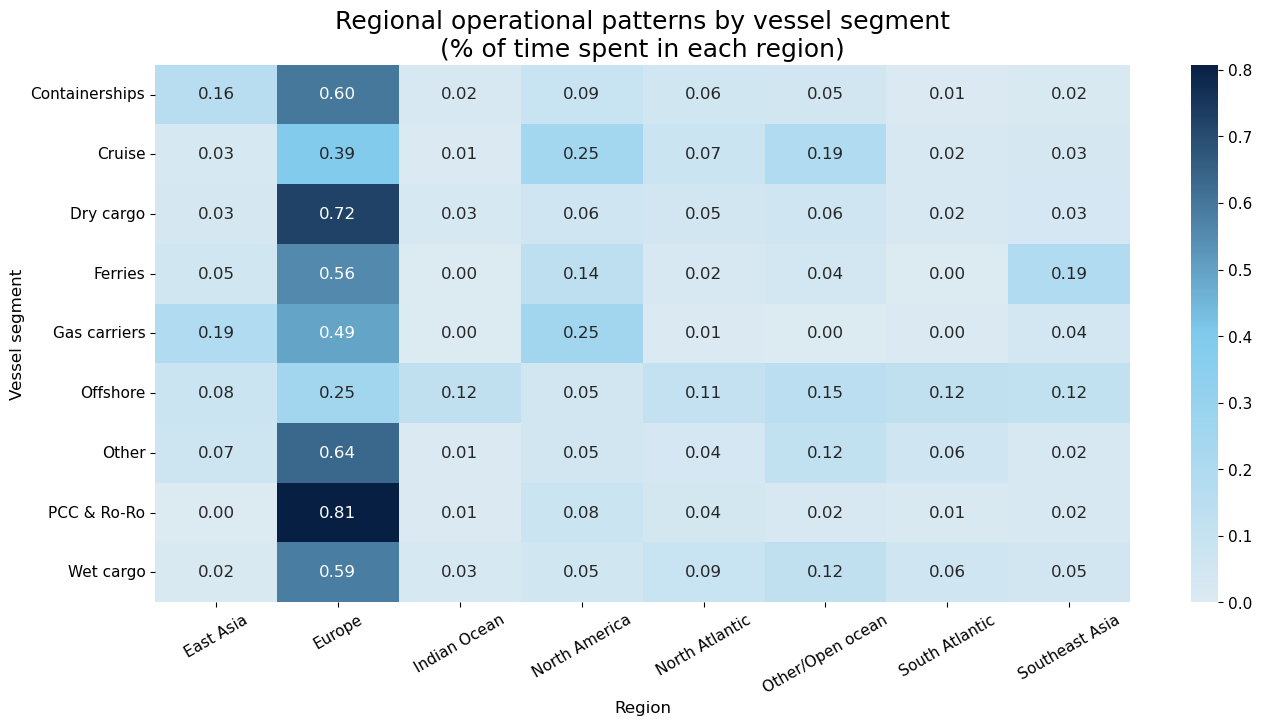

In [34]:
# Regional analysis by segment
region_by_segment = pd.crosstab(df_ais_merged['Vessel Segment'], df_ais_merged['Region'], normalize='index')
plt.figure(figsize=(14, 8))
sns.heatmap(region_by_segment, cmap=continuous_cmap_towhite.reversed(), annot=True, fmt='.2f')
plt.title('Regional operational patterns by vessel segment\n(% of time spent in each region)')
plt.tight_layout()
plt.xticks(rotation=30)
plt.ylabel('Vessel segment')
plt.show()

The analysis of AIS position reports provides a clear picture of where the addressable fleet is operating and how different vessel segments distribute their time across regions. The heatmap of global operating patterns highlights a strong concentration of activity in European waters, particularly in Northern Europe and the Mediterranean. Key shipping corridors can also be seen across the North Atlantic, linking Europe to North America, as well as around East and Southeast Asia, reflecting major global trade flows. Activity in the Indian Ocean and the South Atlantic is visible but clearly less intense, suggesting that repowering opportunities are most likely to be concentrated in European operators.  
This impression is reinforced by the geographical distribution of AIS reports, where Europe dominates with more than 300,000 reports, far surpassing all other regions combined. North America, the Atlantic, and Asia register much smaller volumes of activity, while the open ocean captures long-distance transits but has less relevance for service interventions. Taken together, this indicates that Europe is the core region for repowering opportunities, though operators engaged in transatlantic and Asian routes also could represent a significant secondary market.

Looking at the operational patterns by vessel segment, it becomes evident that dry cargo, Ro-Ro & PCC, wet cargo, and ferries spend the majority of their operating time in Europe, in some cases up to 80%. These are therefore the segments with the highest potential for concentrated repowering activity. Containerships, in contrast, while still strongly present in Europe, also operate substantially in East Asia and on transatlantic routes, pointing to a more global opportunity base. Gas carriers are likewise more dispersed, with notable activity in North America and East Asia, while cruise and offshore vessels display a broad geographical spread.

These operating patterns suggest several factors likely to influence a customer’s decision to repower. Vessels with high utilisation rates in European waters are exposed to greater engine wear, which accelerates the need for main engine replacement. Geographical concentration in Europe also means that Wärtsilä can leverage its existing service hubs to reduce downtime and costs for customers. Segment-specific considerations further play a role: short-sea operators such as ferries and Ro-Ro carriers may be primarily motivated by fuel savings and compliance with EU regulations, while deep-sea operators such as containerships and gas carriers will weigh global service availability and long-haul efficiency more heavily. In all cases, regulatory pressure, particularly from International Maritime Organization (IMO) measures and the EU’s inclusion of shipping in the Emissions Trading System, will be a strong driver of repowering demand, alongside the age profile of the fleet, which indicates that many vessels in these key segments are already approaching the point where repowering becomes a viable alternative to newbuilds.

## Conclusions

The market study demonstrates that Wärtsilä is facing a highly favourable environment for a repowering campaign. The age profile of the addressable fleet shows a pronounced concentration in the prime repowering window of 10–25 years, with nearly half of all vessels in the optimal 15–20-year range. This aligns strongly with the high-potential segments identified, particularly Dry Cargo, Offshore, Wet Cargo, PCC & Ro-Ro, and Cruise, ensuring both volume opportunities and high-value individual projects. Operational analysis highlights distinct vessel utilisation patterns, with short-sea and long-haul trade lines offering the most compelling cases for fuel efficiency and emissions reduction through repowering. Geographical distribution further reinforces Europe as the central market, with additional opportunities linked to transatlantic and Asian routes. Together, these findings suggest that Wärtsilä should prioritise a dual strategy: capturing volume through broad engagement with Dry and Wet Cargo operators, while targeting high-powered, intensively used vessels in Offshore, PCC & Ro-Ro, and Cruise segments for maximum impact. Customer decisions will ultimately be driven by a mix of vessel age, utilisation intensity, geographical operating base, and tightening regulatory pressures, all of which converge to make the current addressable fleet a substantial repowering opportunity.